In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from scipy.fftpack import fft
from scipy import integrate
from obspy import read
import swprocess

In [2]:
segyfile= read("./Train_data/SGY/1.sgy")

In [70]:
names = None
workflow = "time-domain"
trim, trim_begin, trim_end = False, 0, 0.5

# Mute portions of the time-domain record to isolate surface wave energy. No muting is recommended.
# Mute method {"interactive"} and window_kwargs (see documenation for details).
mute, method, window_kwargs = False, "interactive", {}

# Zero pad the time-domain record to achieve a desired frequency step. Padding with df=0.5 is recommended.
pad, df = True, 0.1
transform = "fdbf"

# Minimum and maximum frequencies of interest (frequency in Hertz).
fmin, fmax = 3, 10

# Selection of trial velocities (velocity in m/s) with minimum, maximum, number of steps, and space {"linear", "log"}.  
vmin, vmax, nvel, vspace = 100, 500, 500, "linear"

# Weighting for "fdbf" {"sqrt", "invamp", "none"} (ignored for all other wavefield transforms). "sqrt" is recommended. 
fdbf_weighting = "sqrt"

# Steering vector for "fdbf" {"cylindrical", "plane"} (ignored for all other wavefield transforms). "cylindrical" is recommended.
fdbf_steering = "cylindrical"
snr = False

# Define noise and signal windows being and end times (time in seconds). Negative time refers to pre-trigger record.
noise_begin, noise_end =  0., 0.
signal_begin, signal_end = 0., 0.1

# Zero pad the noise and signal records to achieve a specified frequency step. Padding with df=1 is recommended.
pad_snr, df_snr = True, 1
%matplotlib qt5
settings = swprocess.Masw.create_settings_dict(workflow=workflow,
                                               trim=trim, trim_begin=trim_begin, trim_end=trim_end,
                                               mute=mute, method=method, window_kwargs=window_kwargs,
                                               transform=transform, fmin=fmin, fmax=fmax, pad=pad, df=df,
                                               vmin=vmin, vmax=vmax, nvel=nvel, vspace=vspace,
                                               weighting=fdbf_weighting, steering=fdbf_steering,
                                               snr=snr, noise_begin=noise_begin, noise_end=noise_end,
                                               signal_begin=signal_begin, signal_end=signal_end,
                                               pad_snr = pad_snr, df_snr=df_snr)

#settings = swprocess.Masw.create_settings_dict()
wavefieldtransform = swprocess.Masw.run(fnames="./Train_data/SGY/1.sgy", settings=settings)

In [71]:
wavefield_normalization = "frequency-maximum"

# Display the wavelength resolution limit.
display_lambda_res = False

# Display Yoon and Rix (2009) near-field criteria
display_nearfield = False
number_of_array_center_distances = 1

In [72]:
minimum_snr = 3.2

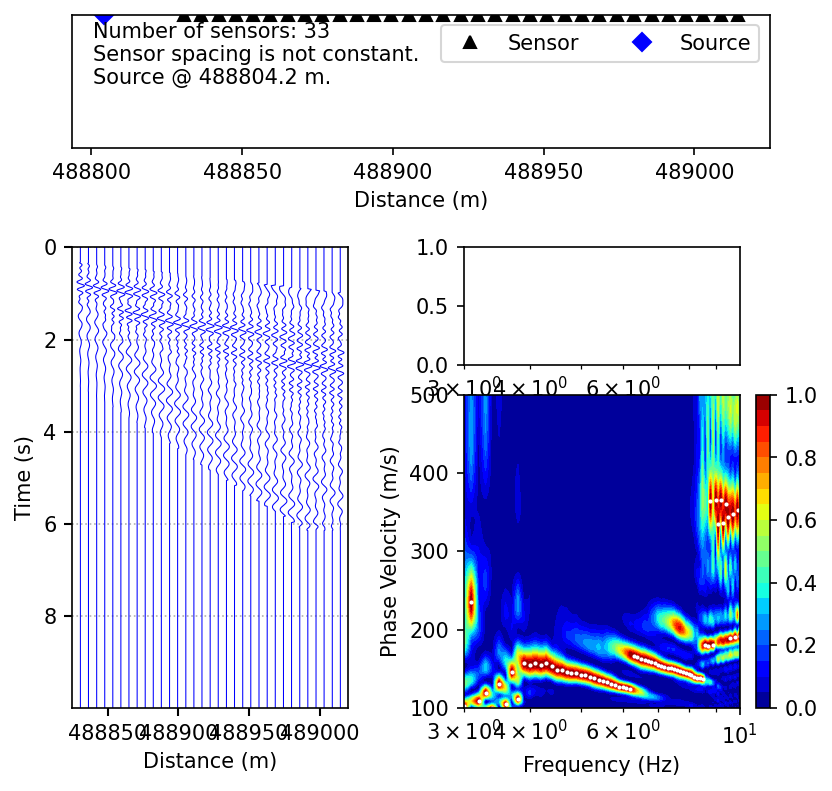

In [73]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# # Signal-to-Noise Ratio
# wavefieldtransform.plot_snr(ax=ax2, plot_kwargs=dict(color="black", label="SNR"))
# xlim = ax2.get_xlim()
# ax2.plot(xlim, [minimum_snr]*2, lw=2, color="red", label="10 dB")
# ax2.set_xlim(xlim)
# ax2.set_xticklabels([])
# ax2.set_xlabel("")
# ax2.set_ylabel("SNR")
# ax2.set_yscale("log")
# ax2.legend(loc="upper left")

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()


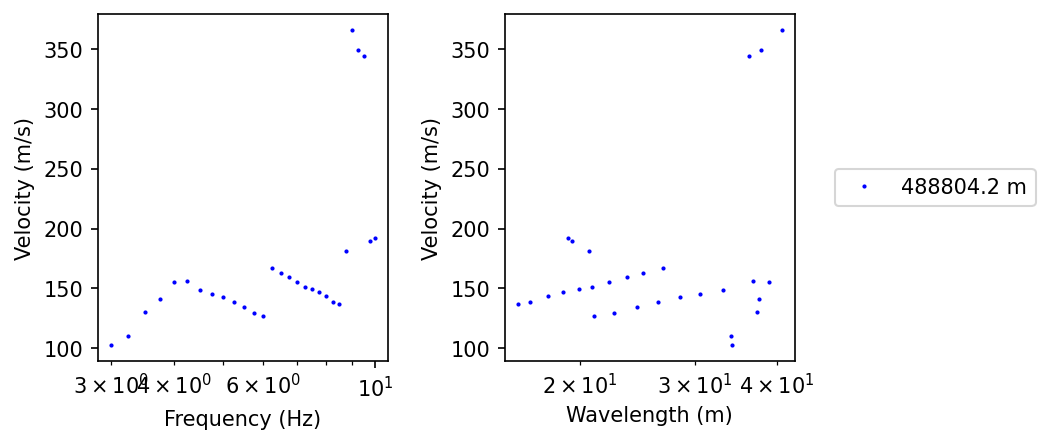

In [36]:
import matplotlib as mpl
# Domains in which to plot the experimental dispersion data.
domains = [
    ["frequency", "velocity"],
    ["wavelength", "velocity"],
]
%matplotlib inline
xtype = [x for x, _ in domains]
ytype = [y for _, y in domains]
label = [f"{wavefieldtransform.array.source.x:.1f} m"]

fig, axs = plt.subplots(ncols=len(xtype), figsize=(6,3), dpi=150, gridspec_kw=dict(wspace=0.4))
peak = swprocess.peaks.Peaks(wavefieldtransform.frequencies,
                             wavefieldtransform.find_peak_power(by="frequency-maximum"),
                             identifier=label)
peaksuite = swprocess.PeaksSuite.from_peaks([peak])
peaksuite.plot(xtype=xtype, ax=axs, ytype=ytype, plot_kwargs=dict(color="blue", label=label))

axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")
plt.show()

In [37]:
wavefieldtransform.find_peak_power(by="frequency-maximum")

array([102.40480962, 110.42084168, 130.46092184, 140.88176353,
       155.31062124, 156.11222445, 148.89779559, 144.88977956,
       142.48496994, 138.47695391, 134.46893788, 129.65931864,
       126.45290581, 167.33466934, 162.5250501 , 159.31863727,
       155.31062124, 151.30260521, 149.6993988 , 146.49298597,
       143.28657315, 138.47695391, 136.87374749, 180.96192385,
       366.13226453, 349.29859719, 344.48897796, 189.77955912,
       192.18436874])

In [38]:
np.linspace(3, 10, 50)

array([ 3.        ,  3.14285714,  3.28571429,  3.42857143,  3.57142857,
        3.71428571,  3.85714286,  4.        ,  4.14285714,  4.28571429,
        4.42857143,  4.57142857,  4.71428571,  4.85714286,  5.        ,
        5.14285714,  5.28571429,  5.42857143,  5.57142857,  5.71428571,
        5.85714286,  6.        ,  6.14285714,  6.28571429,  6.42857143,
        6.57142857,  6.71428571,  6.85714286,  7.        ,  7.14285714,
        7.28571429,  7.42857143,  7.57142857,  7.71428571,  7.85714286,
        8.        ,  8.14285714,  8.28571429,  8.42857143,  8.57142857,
        8.71428571,  8.85714286,  9.        ,  9.14285714,  9.28571429,
        9.42857143,  9.57142857,  9.71428571,  9.85714286, 10.        ])

In [53]:
wl, velo = peaksuite.to_array("wavelength", "velocity", peak.wavelength)
fr, velo1 = peaksuite.to_array("frequency", "velocity", peak.frequency)
velo

array([[102.40480962, 110.42084168, 130.46092184, 140.88176353,
        155.31062124, 156.11222445, 148.89779559, 144.88977956,
        142.48496994, 138.47695391, 134.46893788, 129.65931864,
        126.45290581, 167.33466934, 162.5250501 , 159.31863727,
        155.31062124, 151.30260521, 149.6993988 , 146.49298597,
        143.28657315, 138.47695391, 136.87374749, 180.96192385,
        366.13226453, 349.29859719, 344.48897796, 189.77955912,
        192.18436874]])

In [54]:
velo1

array([[102.40480962, 110.42084168, 130.46092184, 140.88176353,
        155.31062124, 156.11222445, 148.89779559, 144.88977956,
        142.48496994, 138.47695391, 134.46893788, 129.65931864,
        126.45290581, 167.33466934, 162.5250501 , 159.31863727,
        155.31062124, 151.30260521, 149.6993988 , 146.49298597,
        143.28657315, 138.47695391, 136.87374749, 180.96192385,
        366.13226453, 349.29859719, 344.48897796, 189.77955912,
        192.18436874]])

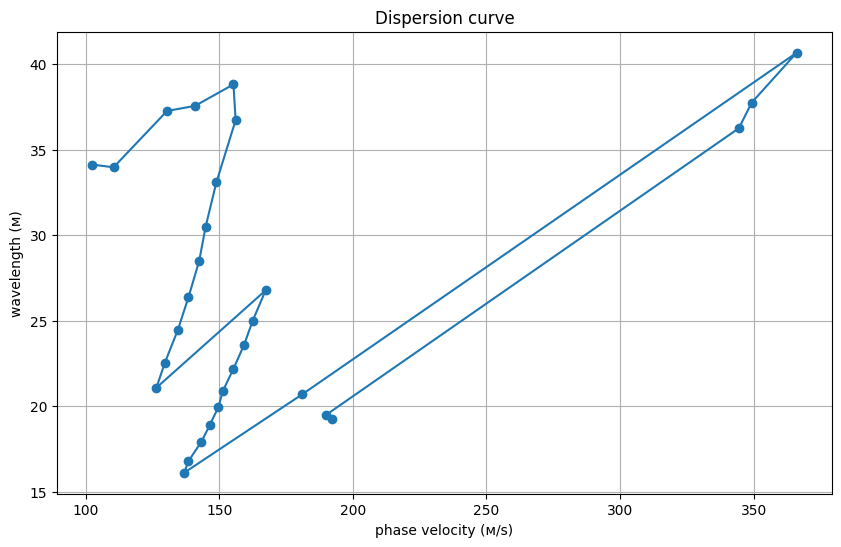

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(velo.reshape((29)), wl, marker='o')
plt.xlabel('phase velocity (м/s)')
plt.ylabel('wavelength (м)')
plt.title('Dispersion curve')
plt.grid(True)
plt.show()

In [68]:
height = velo.reshape((29)) / (2*wl)
#height = 1/(wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*np.pi*wavefieldtransform.frequencies))
height

array([1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 , 2.375, 2.5  ,
       2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375, 3.5  , 3.625,
       3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375, 4.5  , 4.625, 4.75 ,
       4.875, 5.   ])

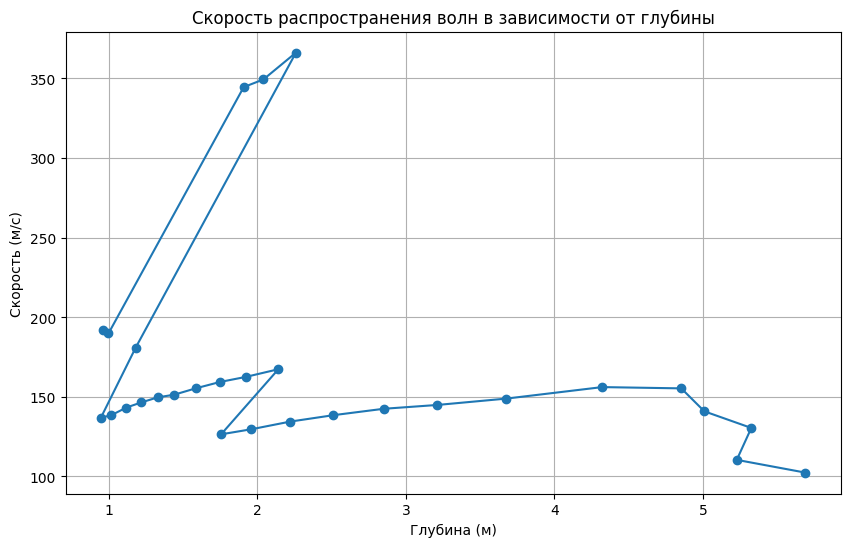

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(height, velo.reshape(29), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

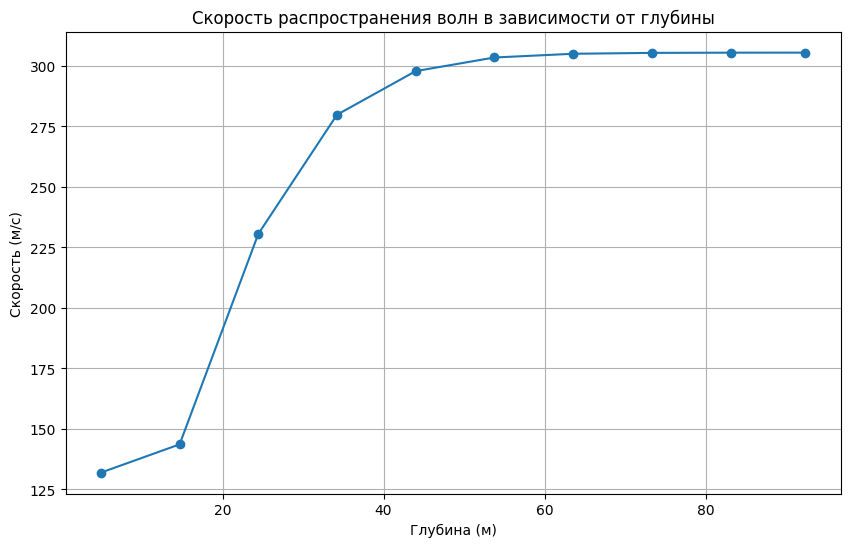

In [59]:
import pandas as pd

data = pd.read_csv(f"./Train_data/TXT/1.txt", delimiter="\t")
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

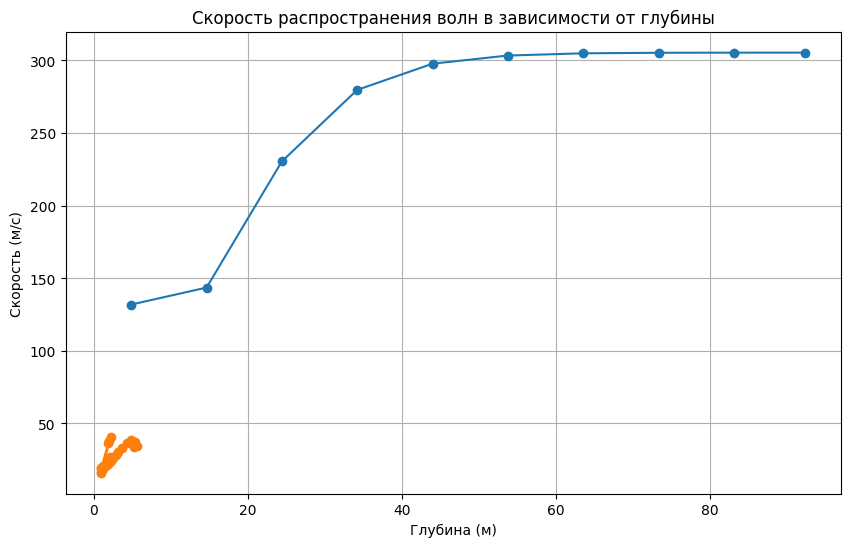

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wl, marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

In [17]:
freq = data['Velocity']/(2*data['Depth'])

In [18]:
freq

0    13.485478
1     4.893162
2     4.714061
3     4.086494
4     3.383045
5     2.820168
6     2.398381
7     2.081123
8     1.836797
9     1.652246
dtype: float64

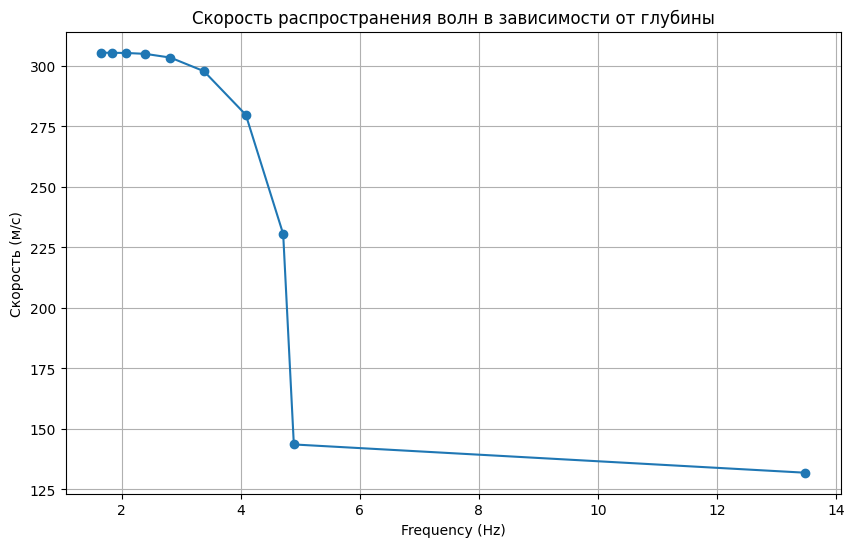

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(freq, data["Velocity"], marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

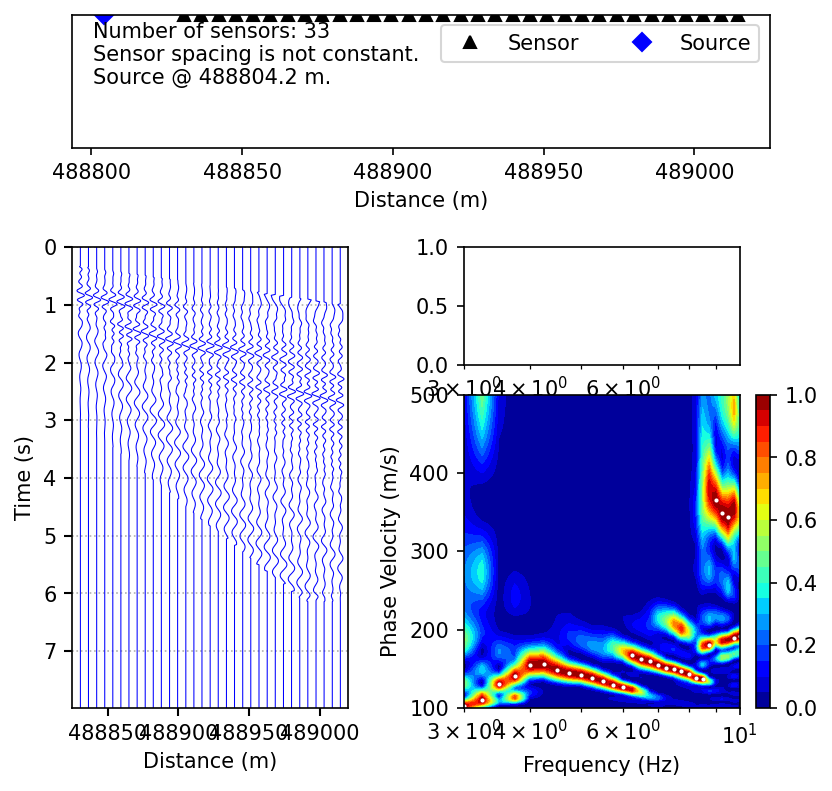

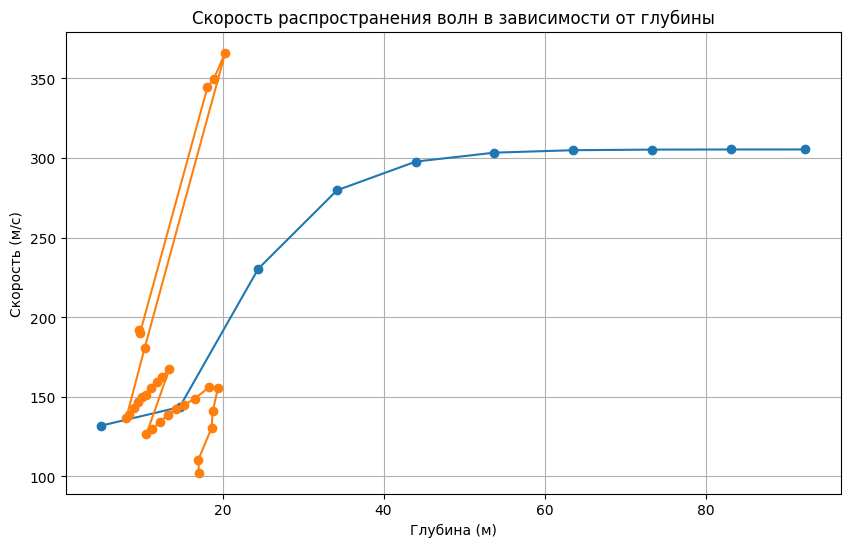

In [69]:
number = 1
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

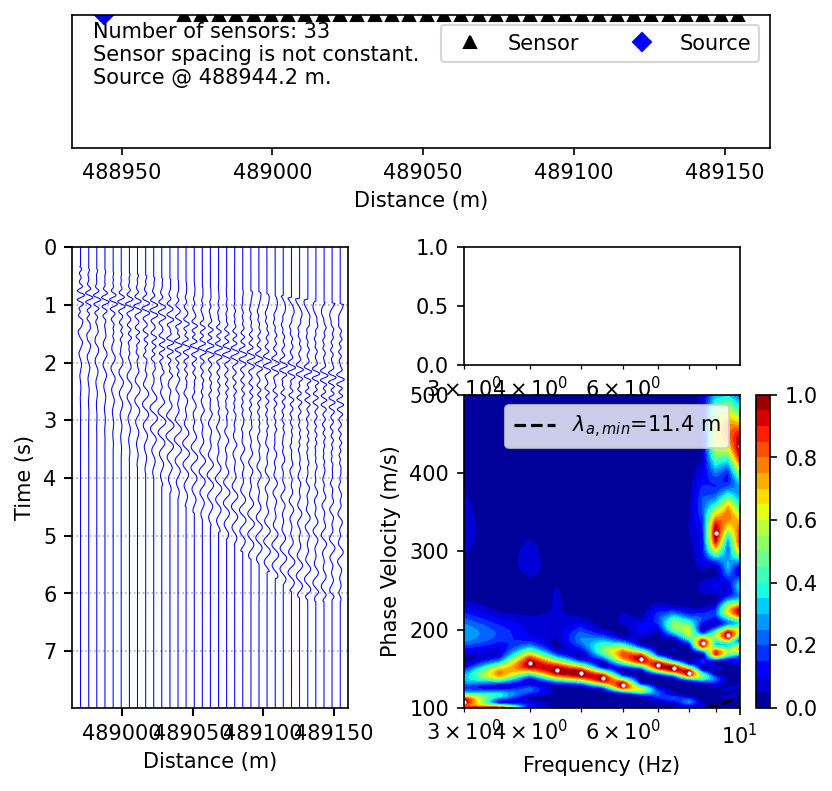

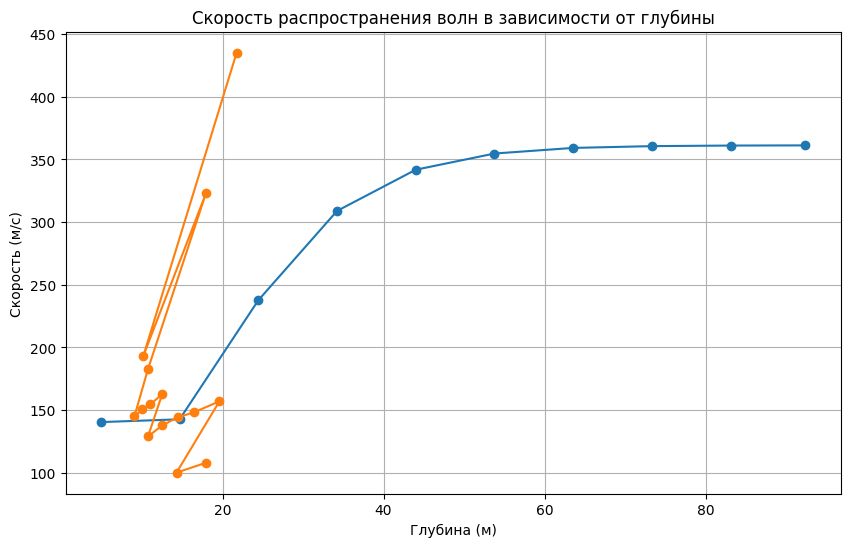

In [17]:
number = 2
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

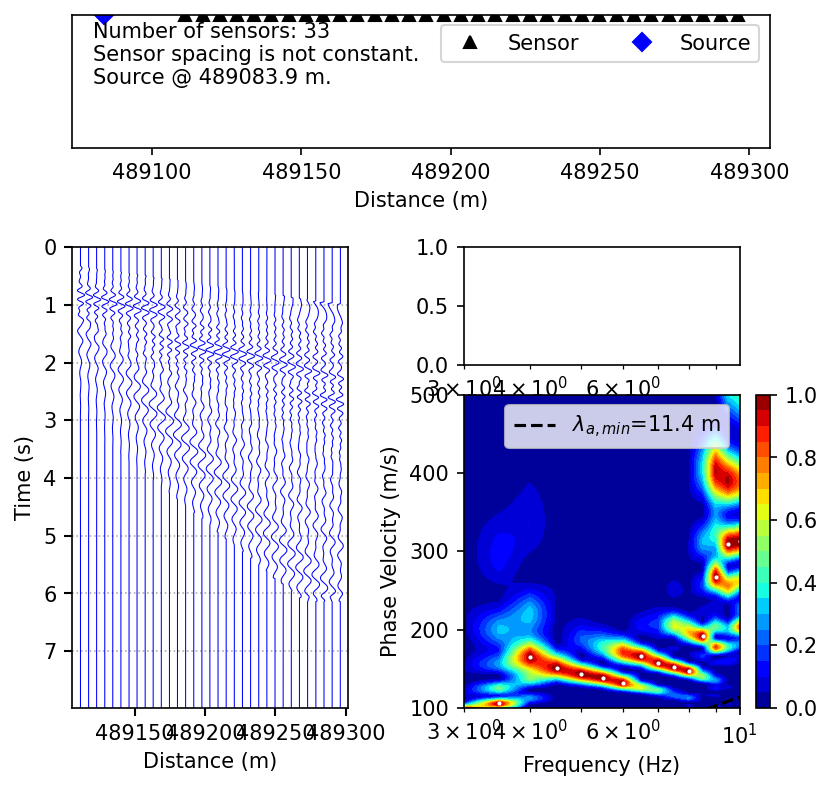

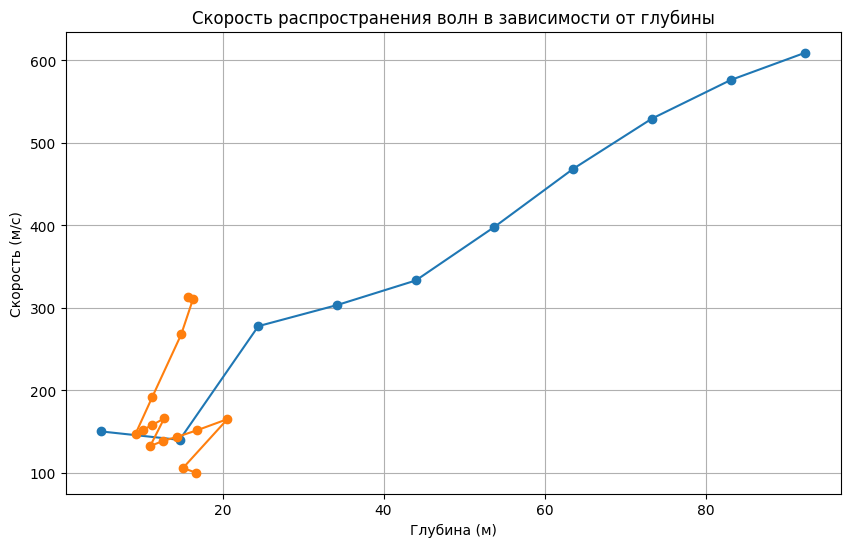

In [18]:
number = 3
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

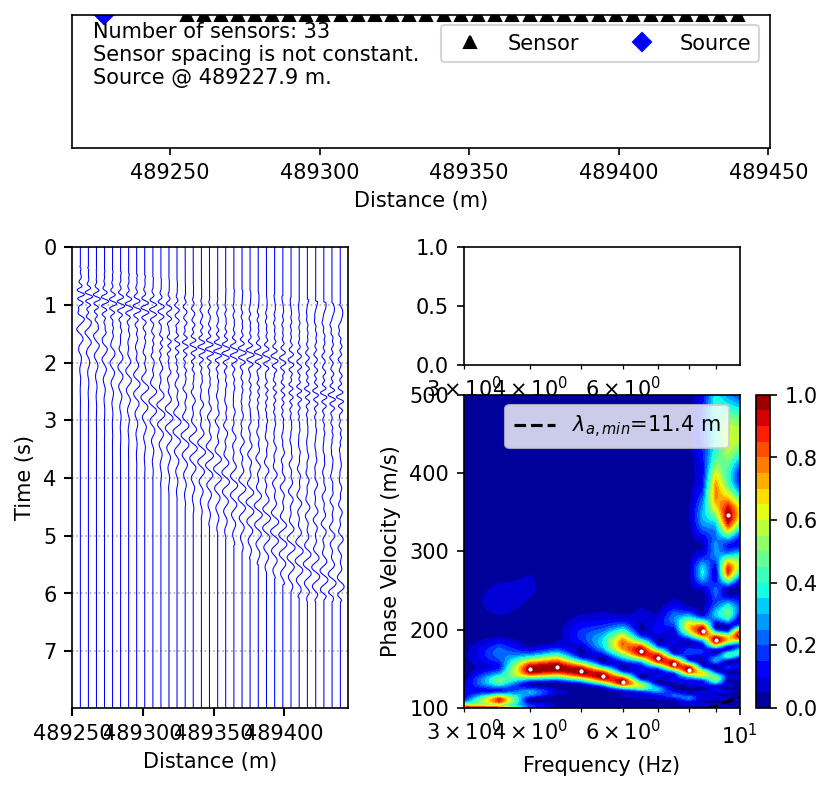

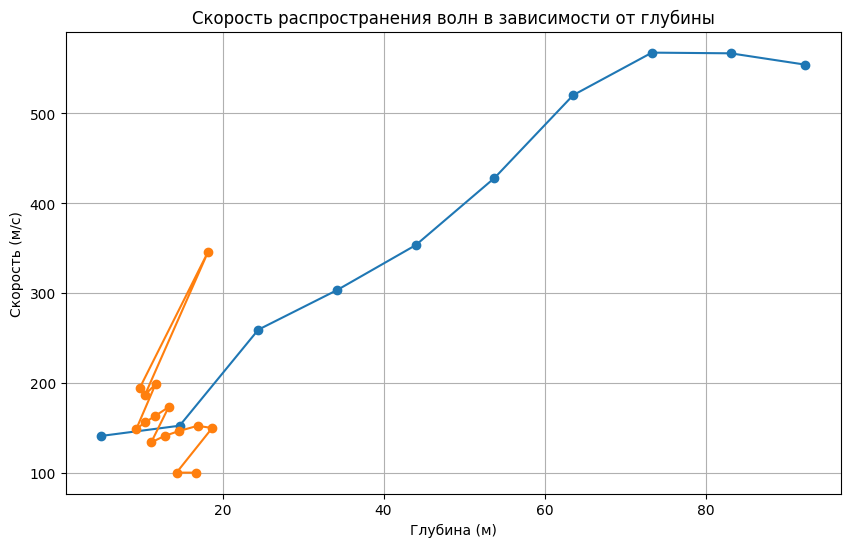

In [19]:
number = 4
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

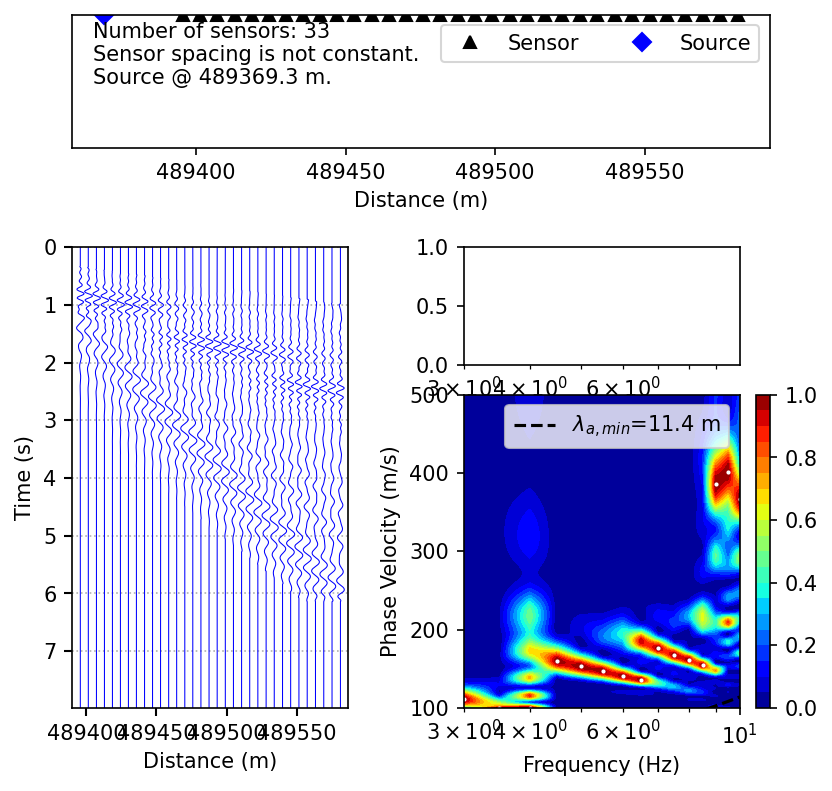

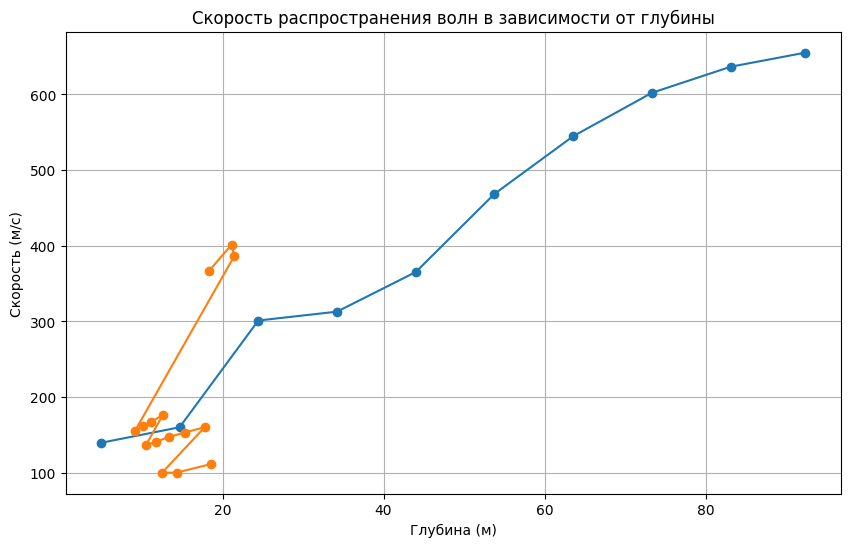

In [20]:
number = 5
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

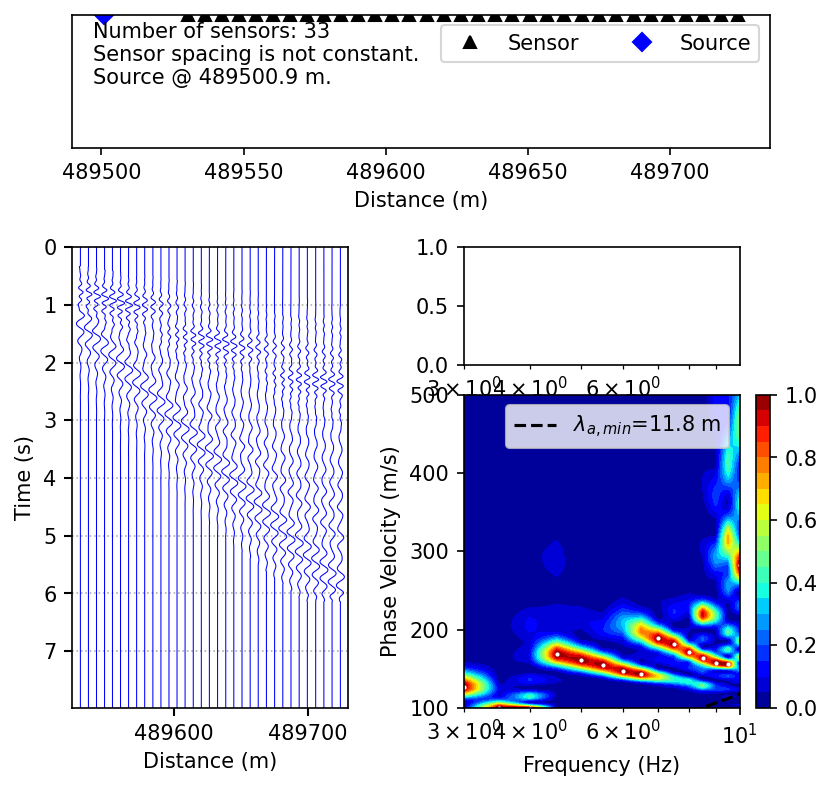

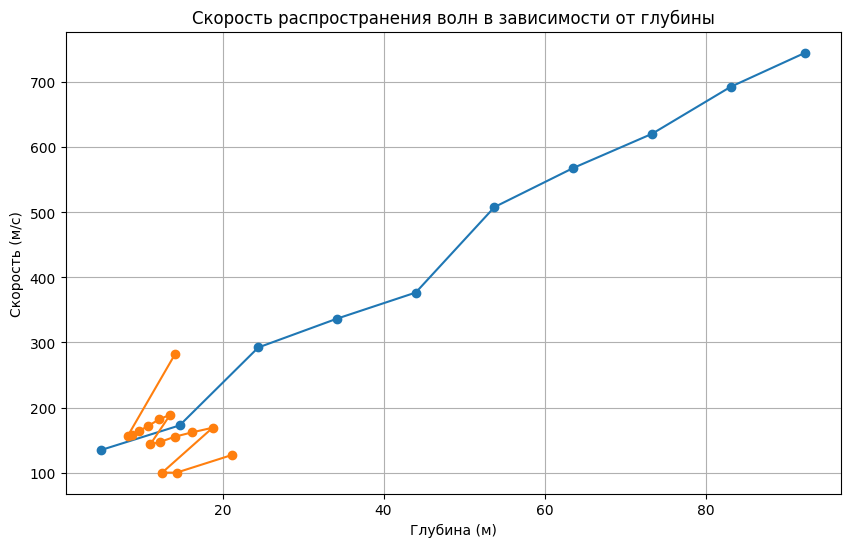

In [21]:
number = 6
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

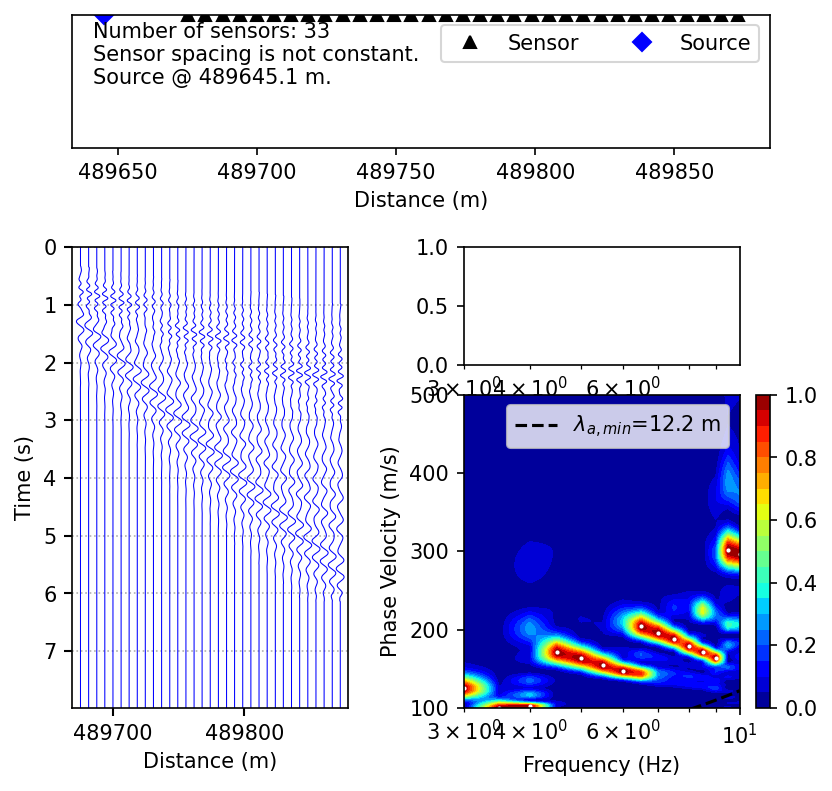

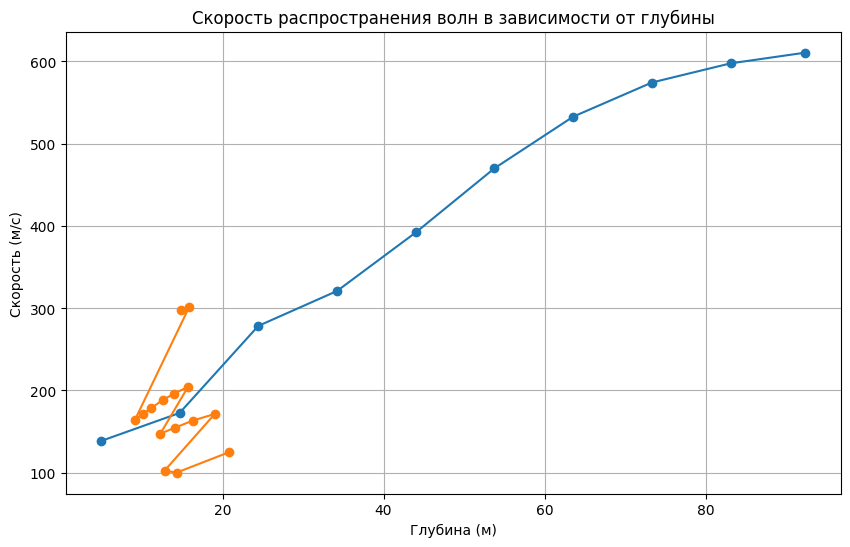

In [22]:
number = 7
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

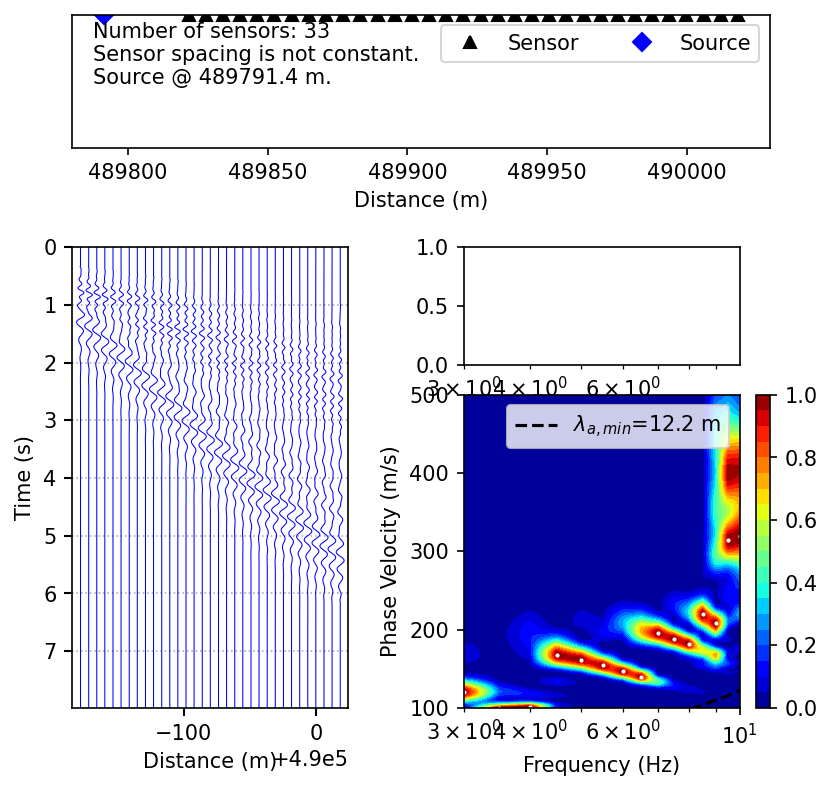

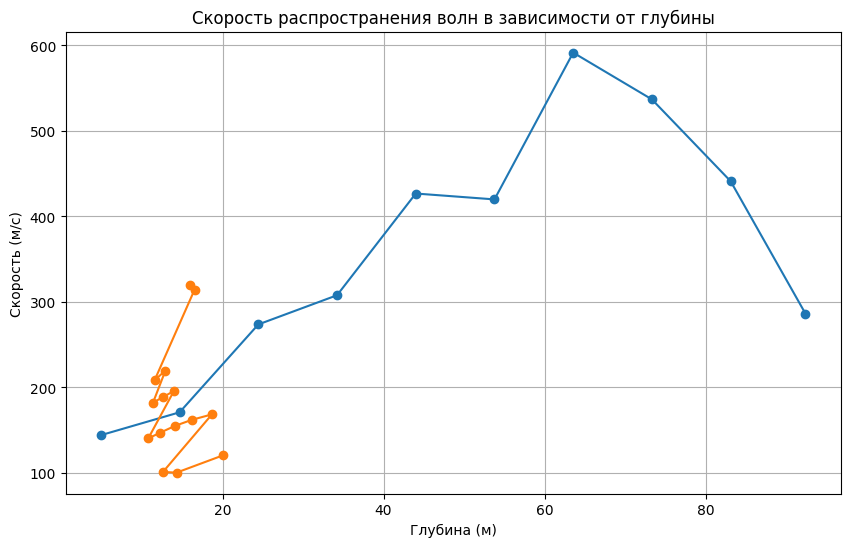

In [23]:
number = 8
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()

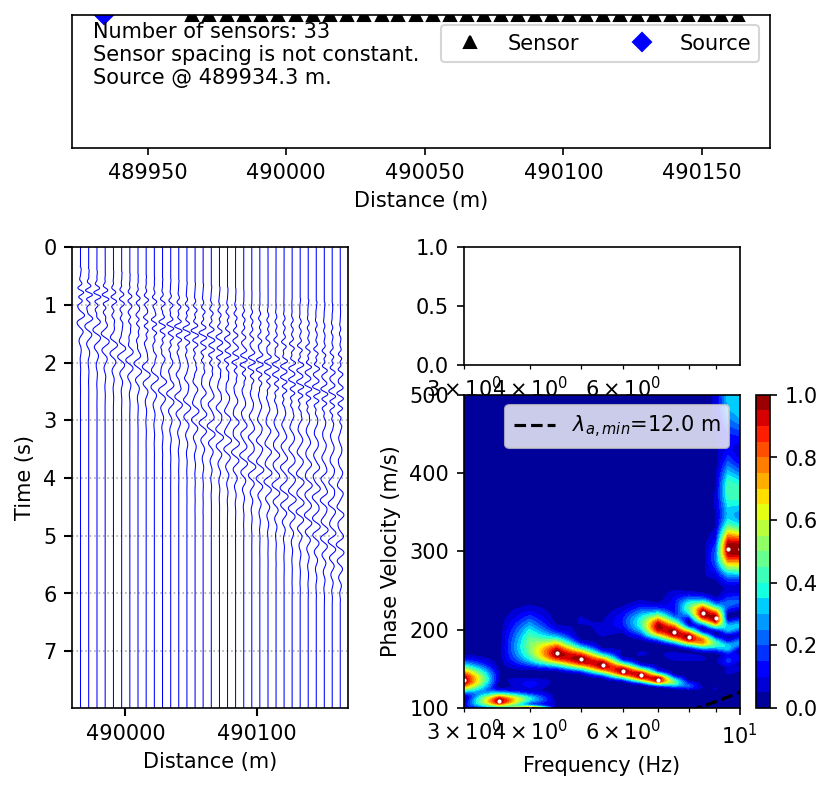

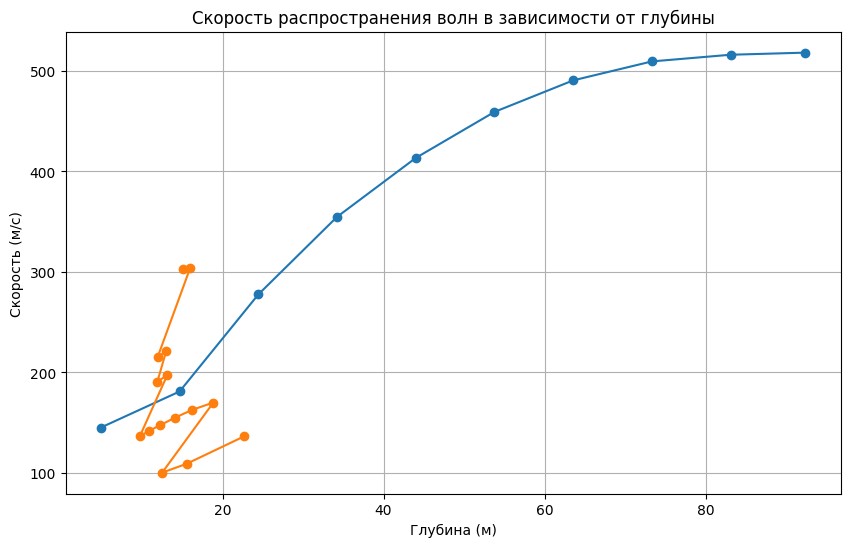

In [24]:
number = 9
wavefieldtransform = swprocess.Masw.run(fnames=f"./Train_data/SGY/{number}.sgy", settings=settings)
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
plt.show()
data = pd.read_csv(f"./Train_data/TXT/{number}.txt", delimiter="\t")
height = wavefieldtransform.find_peak_power(by="frequency-maximum") / (2*wavefieldtransform.frequencies)
plt.figure(figsize=(10, 6))
plt.plot(data["Depth"], data["Velocity"], marker='o')
plt.plot(height, wavefieldtransform.find_peak_power(by="frequency-maximum"), marker='o')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.show()